In [8]:
import numpy as np
import matplotlib.pyplot as plt

y = np.load('./TadGAN/original_1.npy')
y_hat = np.load('./TadGAN/hat_1.npy')

In [2]:
y = y.tolist()[0]

In [3]:
y_hat = y_hat.tolist()[0]

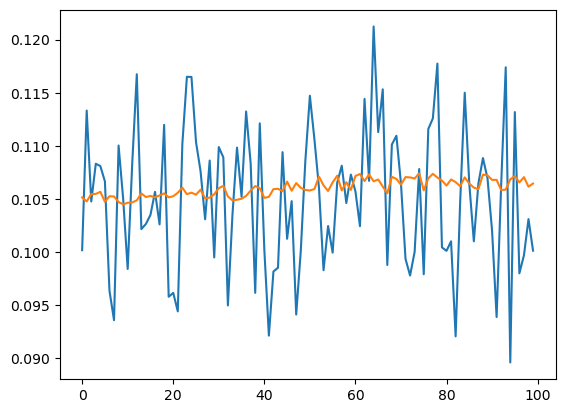

In [4]:
plt.plot(y)
plt.plot(y_hat)

In [58]:
import pandas as pd
bearing = pd.read_csv('C:/Users/dk866/Desktop/bearing_test/data/set2_b1_outer_race_failure.csv')


In [35]:
import csv
file = open('C:/Users/dk866/Desktop/monitoring_system/Data/nothing_90/2023.5.4.9.32.12.46', 'r')
reader = csv.reader(file)

df = []
for row in reader:
    temp = []
    for a in row:
        temp.append(float(a))
        # print(a)
    df.extend(temp)
    # df.extend(row)

# bearing = pd.DataFrame(df)

In [61]:
bearing.columns

Index(['Unnamed: 0', 'B1'], dtype='object')

In [40]:
bearing['signal'][0]

0.008752621837610452

In [62]:
last = 0
signal = []
for i in range(1, len(bearing) // 430):
    temp = np.sqrt(sum(bearing['B1'][last: i * 430] ** 2) / 430)
    signal.append(temp)
    last = i * 430

df = pd.DataFrame()
df['signal'] = signal

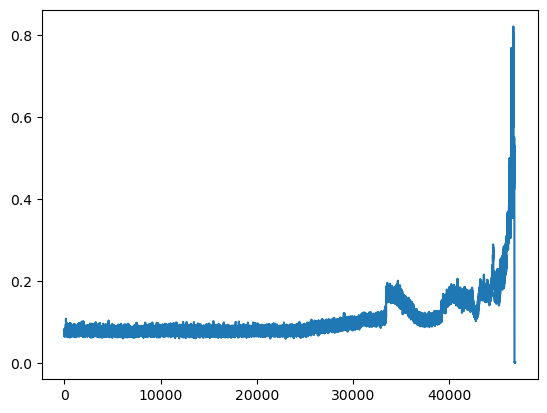

In [63]:
plt.plot(df['signal'])

In [43]:
df['signal'].shape

(3571,)

In [44]:
import torch
from TadGAN.model import Encoder, Decoder, CriticX, CriticZ

encoder = Encoder('./TadGAN/models/encoder.pt').to('cuda:0')
encoder.load_state_dict(torch.load('./TadGAN/models/encoder.pt'))

decoder = Decoder('./TadGAN/models/decoder.pt').to('cuda:0')
decoder.load_state_dict(torch.load('./TadGAN/models/decoder.pt'))

criticz = CriticZ('./TadGAN/models/critic_z.pt').to('cuda:0')
criticz.load_state_dict(torch.load('./TadGAN/models/critic_z.pt'))
criticx = CriticX('./TadGAN/models/critic_x.pt').to('cuda:0')
criticx.load_state_dict(torch.load('./TadGAN/models/critic_x.pt'))

<All keys matched successfully>

In [10]:
print(encoder)

Encoder(
  (lstm): LSTM(100, 20, bidirectional=True)
  (dense): Linear(in_features=40, out_features=20, bias=True)
)


In [64]:
df['anomaly'] = 0
# signal_list = list()
# for i in range(-50, 50):
#     signal_list.append('signal' + str(i))

# for i in range(-50, 50):
#     df['signal'+str(i)] = df['signal'].shift(i)
# # drop NaN value and reset index
# df = df.dropna()
# df = df.reset_index(drop=True)


In [65]:
df = df.reset_index(drop=True)

In [47]:
class tester(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.columns = self.make_signal_list()
        self.make_rolling_signals()

    def make_signal_list(self):
        signal_list = list()
        for i in range(-50, 50):
            signal_list.append('signal'+str(i))
        return signal_list
        
    def make_rolling_signals(self) -> None:
        """
        Making dataset index as cycle
        """
        for i in range(-50, 50):
            self.dataset['signal'+str(i)] = self.dataset['signal'].shift(i)
        # drop NaN value and reset index
        self.dataset = self.dataset.dropna()
        self.dataset = self.dataset.reset_index(drop=True)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        row = self.dataset.loc[idx]
        x = row[self.columns].values.astype(float)
        x = torch.from_numpy(x)
        return {'signal': x, 'anomaly': row['anomaly']}

In [66]:
T = tester(df)
T.dataset.shape

C:\Users\dk866\AppData\Local\Temp\ipykernel_12352\3289213003.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.dataset['signal'+str(i)] = self.dataset['signal'].shift(i)
C:\Users\dk866\AppData\Local\Temp\ipykernel_12352\3289213003.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.dataset['signal'+str(i)] = self.dataset['signal'].shift(i)


(46763, 102)

In [68]:
test_loader = torch.utils.data.DataLoader(tester(df[30000:]), batch_size=64, drop_last=True) #, collate_fn=lambda x: default_collate(x).to(device))

C:\Users\dk866\AppData\Local\Temp\ipykernel_12352\3289213003.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataset['signal'+str(i)] = self.dataset['signal'].shift(i)


In [69]:
print(test_loader)

In [70]:
reconstruction_list = list()
for batch, sample in enumerate(test_loader):
    print(len(sample['signal'][0]))
    reconstruction_signal = decoder(encoder(sample['signal']))
    reconstruction_signal = torch.squeeze(reconstruction_signal)
    reconstruction_list.extend(reconstruction_signal.detach().cpu().numpy()[0])
    print(reconstruction_signal.shape)

100
torch.Size([64, 100])
100
torch.Size([64, 100])
100
torch.Size([64, 100])
100
torch.Size([64, 100])
100
torch.Size([64, 100])
100
torch.Size([64, 100])
100
torch.Size([64, 100])
100
torch.Size([64, 100])
100
torch.Size([64, 100])
100
torch.Size([64, 100])
100
torch.Size([64, 100])
100
torch.Size([64, 100])
100
torch.Size([64, 100])
100
torch.Size([64, 100])
100
torch.Size([64, 100])
100
torch.Size([64, 100])
100
torch.Size([64, 100])
100
torch.Size([64, 100])
100
torch.Size([64, 100])
100
torch.Size([64, 100])
100
torch.Size([64, 100])
100
torch.Size([64, 100])
100
torch.Size([64, 100])
100
torch.Size([64, 100])
100
torch.Size([64, 100])
100
torch.Size([64, 100])
100
torch.Size([64, 100])
100
torch.Size([64, 100])
100
torch.Size([64, 100])
100
torch.Size([64, 100])
100
torch.Size([64, 100])
100
torch.Size([64, 100])
100
torch.Size([64, 100])
100
torch.Size([64, 100])
100
torch.Size([64, 100])
100
torch.Size([64, 100])
100
torch.Size([64, 100])
100
torch.Size([64, 100])
100
torch.Si

In [71]:
len(reconstruction_list)

26100

In [72]:
len(df['signal'])

46862

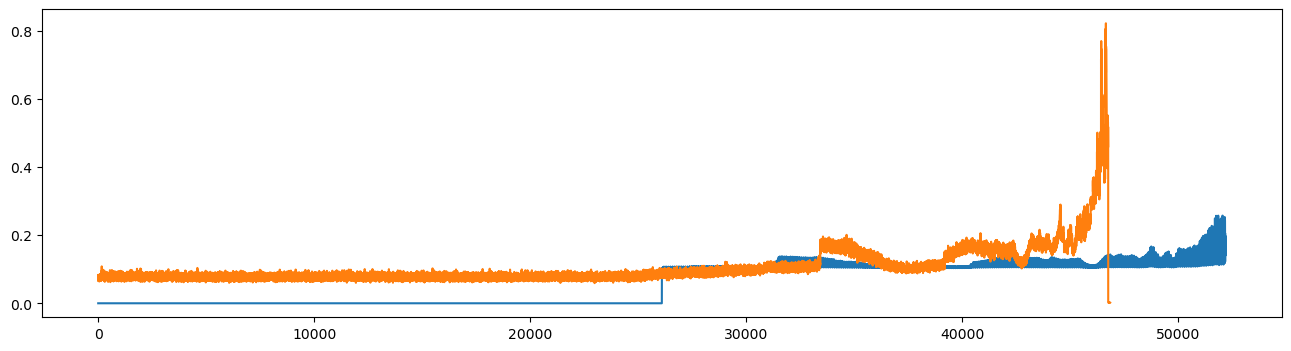

In [78]:
plt.figure(figsize=[16, 4])
# plt.plot(df['signal'])
plt.plot([0 for _ in range(26100)] + reconstruction_list[:])
plt.plot(df['signal'])